This file attempts to build a baseline model for the given problem.

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    fbeta_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score
)
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import copy


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morbenari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/morbenari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv('../data/Supplementary data - responses and measures.csv', index_col=False)


In [5]:
NUM_LABELS = df['EmpathyQ_1'].dropna().unique().shape[0]
NUM_LABELS

10

## Clean the text data

Remove punctuation, numbers, and special characters.
Convert text to lowercase.
Tokenize the paragraphs into words.

In [6]:
def process_text(x):
    """
    Process an english paragraph: removes punctuation, convert text to lower-case and tokenize the paragraph into words
    """
    x = re.sub(r"\W+", " ", x) #remove punctuation
    x = x.lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = tokenizer.tokenize(x)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    return lemmas
    
    

In [7]:
df['Response'] = df['Response'].fillna("")
df['Response'] = df['Response'].astype(str)

# Create out X matrix

In [8]:
X_mat = pd.DataFrame()
X_mat['study1'] = df['StudyNum'].apply(lambda x: 1 if x==1 else 0)
X_mat['study2'] = df['StudyNum'].apply(lambda x: 1 if x==2 else 0)
X_mat['study3'] = df['StudyNum'].apply(lambda x: 1 if x==3 else 0)
X_mat['study4'] = df['StudyNum'].apply(lambda x: 1 if x==4 else 0)


In [9]:
X_mat

,study1,study2,study3,study4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
3466,0,0,0,0
3467,0,0,0,0
3468,0,0,0,0
3469,0,0,0,0


## Get 10 most common words

In [10]:
stopwords_english = stopwords.words('english')


In [11]:
def count_words_freq(text):
  if pd.isnull(text):
    return text
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokens = tokenizer.tokenize(text)
  lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords_english]
  return Counter(lemmas)

In [12]:
def get_n_most_common_words(data: pd.DataFrame, n: int, plot: bool = True, title_prefix: str = ""):
    data['Response'] = data['Response'].astype('str') # Some rows are none, so convert all rows type to str
    all_text = ' '.join(data['Response'])
    all_text = all_text.lower()
    cnt_of_each_token = count_words_freq(all_text)
    n_most_common = cnt_of_each_token.most_common(n)
    if plot:
        n_most_common.sort(key=lambda x: x[1], reverse=True)
        words = [item[0] for item in n_most_common]
        counts = [item[1] for item in n_most_common]
        plt.bar(words, counts, width=0.5)
        plt.xlabel('Words')
        plt.xticks(rotation=45)
        plt.ylabel('Frequency')
        plt.title(f'{title_prefix}: Word Frequency Bar Plot For n={n}')
        plt.show()
    else:
      return n_most_common



In [13]:
n_most_common = get_n_most_common_words(df, n=5, plot=False)

In [14]:
n_most_common

[('feeling', 1672),
 ('must', 1667),
 ('sorry', 1633),
 ('hear', 1626),
 ('feel', 1489)]

In [15]:
# Tokenize and lemmatize the response column
X_mat['Response'] = df['Response'].apply(lambda x: x.lower() if not pd.isnull(x) else "") # A temp column in order to help up process the tokens

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = nltk.stem.WordNetLemmatizer()

X_mat['tokens'] = X_mat['Response'].apply(lambda x: tokenizer.tokenize(x))
X_mat['tokens'] = X_mat['tokens'].apply(lambda x: [lemmatizer.lemmatize(t) for t in x if t not in stopwords_english])


# add 10 column that represent the 10 popular words, and indicate whether the given response has those words
for i in range(len(n_most_common)):
    word = n_most_common[i][0]
    X_mat[f"pop_word_{i+1}"] = X_mat['tokens'].apply(lambda x: x.count(word) if word in x else 0)

X_mat['length'] = X_mat['tokens'].apply(lambda x: len(x))

In [16]:
X_mat

,study1,study2,study3,study4,Response,tokens,pop_word_1,pop_word_2,pop_word_3,pop_word_4,pop_word_5,length
0,1,0,0,0,i'm so sorry to hear about the distressing tim...,"[sorry, hear, distressing, time, son, imagine,...",0,1,1,1,0,27
1,1,0,0,0,i'm so sorry to hear about your mum's accident...,"[sorry, hear, mum, accident, must, incredibly,...",0,1,1,2,0,21
2,1,0,0,0,i'm really sorry to hear about the immense str...,"[really, sorry, hear, immense, stress, anxiety...",0,1,1,1,2,39
3,1,0,0,0,i'm really sorry that you're having to experie...,"[really, sorry, experience, sound, incredibly,...",0,0,1,0,0,30
4,1,0,0,0,i'm truly sorry to hear about what happened to...,"[truly, sorry, hear, happened, etsy, business,...",0,1,1,1,1,33
...,...,...,...,...,...,...,...,...,...,...,...,...
3466,0,0,0,0,,[],0,0,0,0,0,0
3467,0,0,0,0,,[],0,0,0,0,0,0
3468,0,0,0,0,,[],0,0,0,0,0,0
3469,0,0,0,0,,[],0,0,0,0,0,0


## Fill nan values

In [17]:
X_mat = X_mat.fillna(0)

# Create the y vector

In [18]:
def create_X_y(array, y_colname: str, y_type: str, cols_to_use: list[str]):
    data = array.copy()
    y = df[y_colname]
    null_indexes = y[y.isna()].index.tolist()
    y = y.dropna()
    if y_type == "binary":
        y = y.apply(lambda x: 1 if x> 6 else 0)
    if y_type == "levels":
        y = y.apply(lambda x: 0 if x <= 3 else (1 if x <= 6 else 2))
    data = data.drop(null_indexes)
    tokens = data['tokens']
    data = data.drop(columns = ['Response', 'tokens'])
    data = data[cols_to_use]
    tokens = tokens.apply(lambda x: ' '.join(x))
    tokens = np.array(tokens)
    return data,y, tokens


In [19]:
X, y, tokens = create_X_y(X_mat, 'EmpathyQ_1', 'original', ["length", "pop_word_1", "pop_word_2"])
X_binary, y_binary, tokens_binary = create_X_y(X_mat, 'EmpathyQ_1', 'binary', ["length", "pop_word_1", "pop_word_2"])

We need to dtop the null values from y, and respectevly, remove those rows from X

# Baseline

In [20]:
def create_conf_matrix(y_test, y_pred, model_name: str, num_labels: int = 10):
    labels = list(range(num_labels))
    conf_mat = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    fig, ax = plt.subplots(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
    disp.plot(cmap='viridis', ax=ax, values_format='.3f')
    disp.ax_.set_title(f"{model_name}")
    plt.tight_layout()
    plt.show()

In [21]:
def plot_label_distribution(preds, title="Predicted Label Distribution"):
    label_counts = pd.Series(preds).value_counts().sort_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## TF-IDF and word embedding

In [22]:
def get_tf_idf_x(x_matrix, tokens):
    vectorizer = TfidfVectorizer(max_features=200)
    X_text = vectorizer.fit_transform(tokens)
    tfidf_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=x_matrix.index)
    return pd.concat([tfidf_df, x_matrix], axis=1)


def get_embedding(x_matrix, tokens):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    X_text = model.encode(tokens, show_progress_bar=True)
    emb_df = pd.DataFrame(X_text, columns=[f"embedding_{i}" for i in range(X_text.shape[1])], index=x_matrix.index)
    return pd.concat([emb_df, x_matrix], axis=1)


In [23]:
x_tf_idf = get_tf_idf_x(X, tokens)
x_sbert_embedding = get_embedding(X, tokens)

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

## Linear Regression

We tried linear regression but we did not use it evetually.

In [24]:
def run_linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = np.round(reg.predict(X_test))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = reg.score(X_test, y_test)
    evs = explained_variance_score(y_test, y_pred)
    print(f"mse = {mse}")
    print(f"mae = {mae}")
    print(f"rmse = {rmse}")
    print(f"r2 = {r2}")
    print(f"explained variance = {evs}")

In [25]:
run_linear_regression(x_tf_idf, y)
run_linear_regression(x_sbert_embedding, y)

mse = 3.338
mae = 1.314
rmse = 1.827019430657485
r2 = -0.18874082250918556
explained variance = -0.23933263927976878
mse = 3.568
mae = 1.328
rmse = 1.888915032498815
r2 = -0.2653886640965635
explained variance = -0.32464627772934596


## Random Forest

In [26]:
def run_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    clf.feature_importances_
    return y_test, y_pred, clf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.836
              precision    recall  f1-score   support

           0       0.29      0.03      0.05        79
           1       0.84      0.99      0.91       421

    accuracy                           0.84       500
   macro avg       0.56      0.51      0.48       500
weighted avg       0.76      0.84      0.77       500



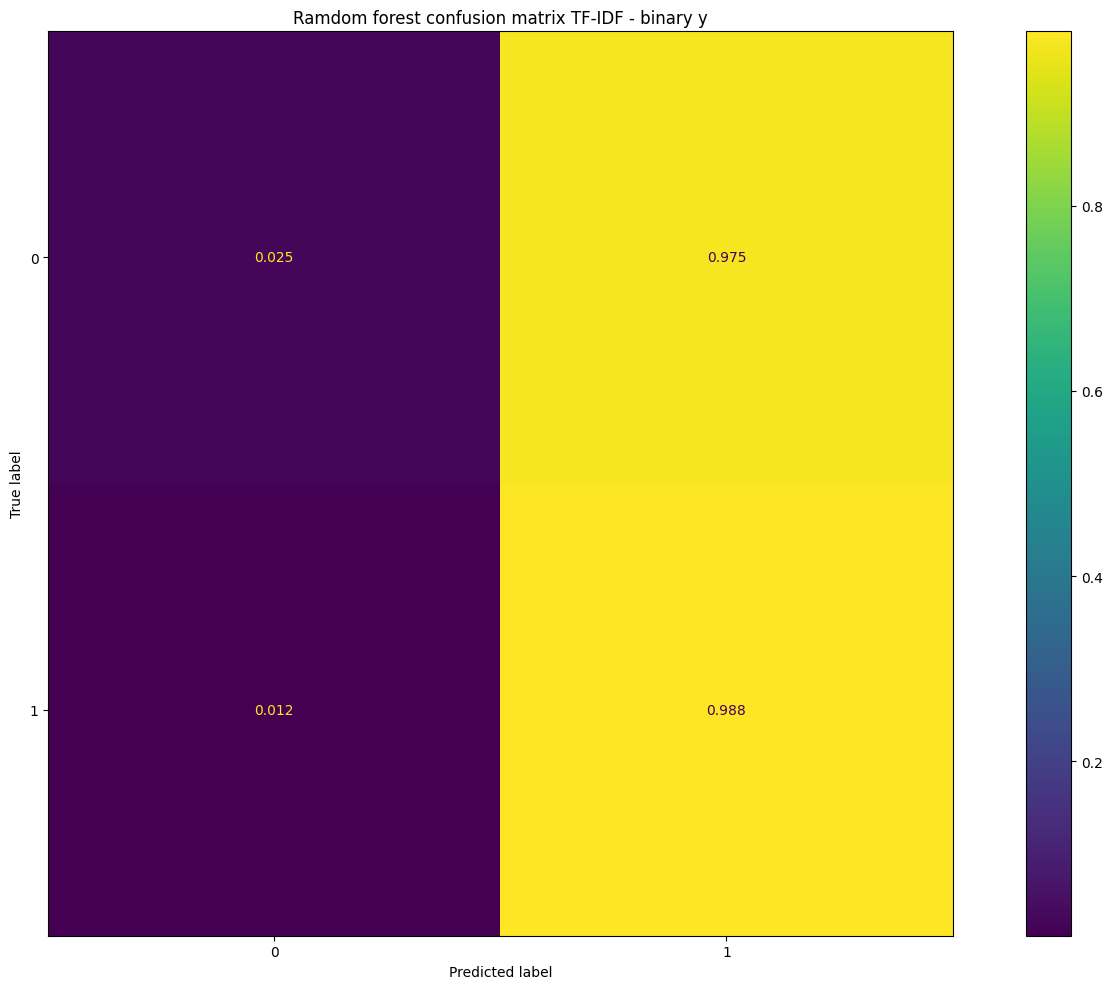

In [27]:
rf_y_test_binary, rf_y_pred_binary, rf_model_binary_tf = run_random_forest(x_tf_idf, y_binary)
create_conf_matrix(rf_y_test_binary, rf_y_pred_binary, "Ramdom forest confusion matrix TF-IDF - binary y", num_labels=2)

Accuracy: 0.818
              precision    recall  f1-score   support

           0       0.23      0.06      0.10        79
           1       0.85      0.96      0.90       421

    accuracy                           0.82       500
   macro avg       0.54      0.51      0.50       500
weighted avg       0.75      0.82      0.77       500



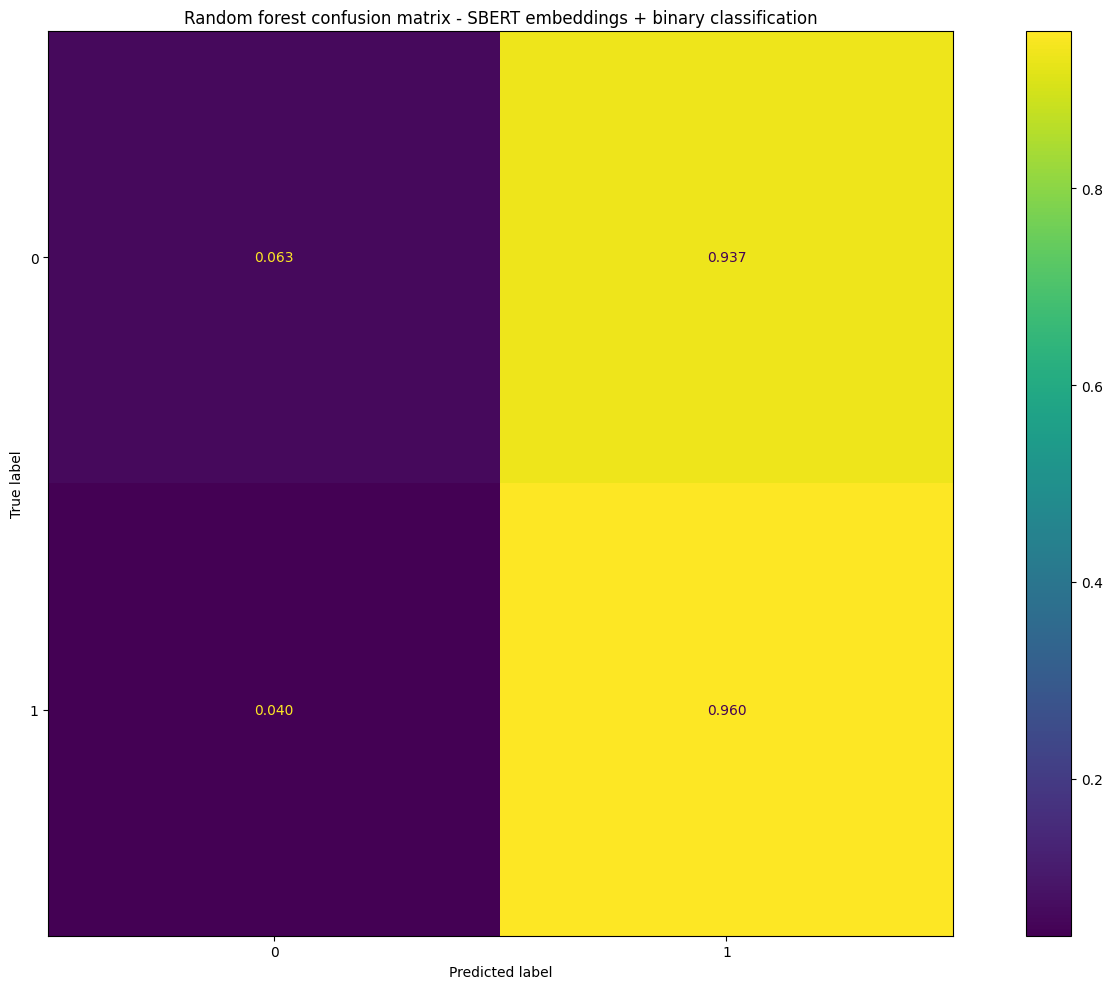

In [28]:
rf_y_test_emb, rf_y_pred_emb, rf_model_binary_emb = run_random_forest(x_sbert_embedding, y_binary)
create_conf_matrix(rf_y_test_emb, rf_y_pred_emb, "Random forest confusion matrix - SBERT embeddings + binary classification", num_labels=2)

Accuracy: 0.426
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        35
         7.0       0.33      0.06      0.11        80
         8.0       0.25      0.07      0.11       118
         9.0       0.44      0.89      0.59       223

    accuracy                           0.43       500
   macro avg       0.17      0.15      0.13       500
weighted avg       0.31      0.43      0.31       500



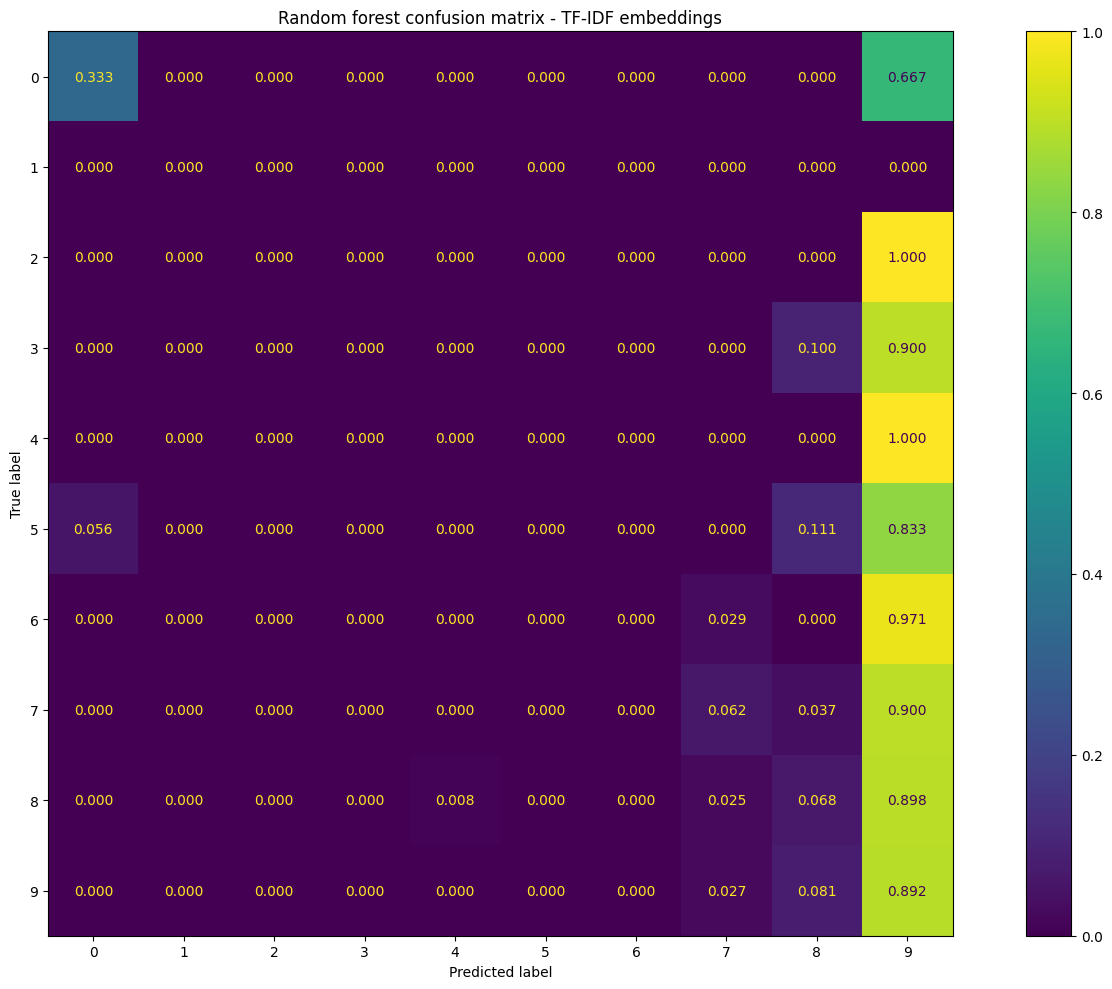

In [29]:
rf_y_test, rf_y_pred, rf_model_tf = run_random_forest(x_tf_idf, y)
create_conf_matrix(rf_y_test, rf_y_pred, "Random forest confusion matrix - TF-IDF embeddings")

Accuracy: 0.354
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00        18
         6.0       0.08      0.06      0.07        35
         7.0       0.20      0.20      0.20        80
         8.0       0.20      0.18      0.19       118
         9.0       0.48      0.61      0.54       223

    accuracy                           0.35       500
   macro avg       0.16      0.15      0.15       500
weighted avg       0.30      0.35      0.32       500



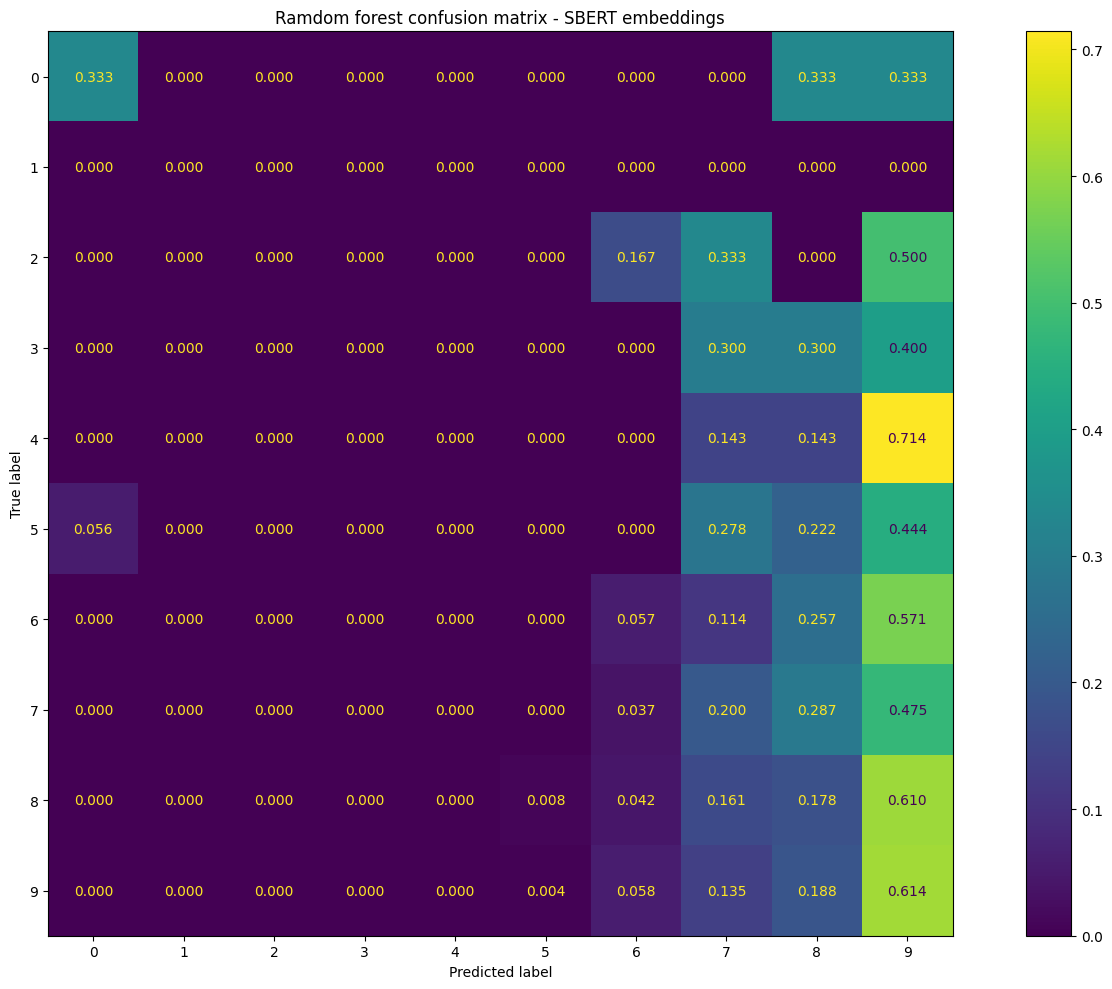

In [30]:
rf_y_test_emb, rf_y_pred_emb, rf_model_emb = run_random_forest(x_sbert_embedding, y)
create_conf_matrix(rf_y_test_emb, rf_y_pred_emb, "Ramdom forest confusion matrix - SBERT embeddings")

# Improved model 

In [31]:
def run_xgboost(X, y, feature_type: str):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    title = f"XGBoost feature importance: {feature_type}"
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    xgb_model = XGBClassifier(
    objective='multi:softprob',  # Softmax with probabilities
    num_class=NUM_LABELS,
    eval_metric='mlogloss',
    use_label_encoder=False,  
    n_estimators=500,         
    learning_rate=0.05,       
    gamma=0.1,                
    subsample=0.8,            
    colsample_bytree=0.8,     
    scale_pos_weight=10,
    random_state = 42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    beta = 2
    f_beta = fbeta_score(y_test, y_pred, beta=beta, average="weighted")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"F-{beta} score: {f_beta:.2f}")

    plt.figure(figsize=(8, 5))
    ax = plot_importance(xgb_model, importance_type='gain', title=title, max_num_features=10)
    for text in ax.texts:
        text.set_visible(False)
    plt.tight_layout()
    plt.show()


    return y_pred, y_test, X_train, X_test, y_train, xgb_model

Test Accuracy: 0.38
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        35
         7.0       0.13      0.06      0.08        80
         8.0       0.27      0.11      0.16       118
         9.0       0.43      0.77      0.55       223

    accuracy                           0.38       500
   macro avg       0.15      0.14      0.13       500
weighted avg       0.28      0.38      0.30       500

F-2 score: 0.34


<Figure size 800x500 with 0 Axes>

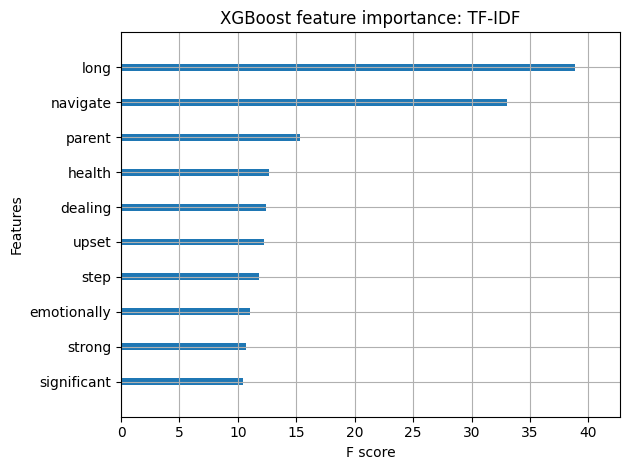

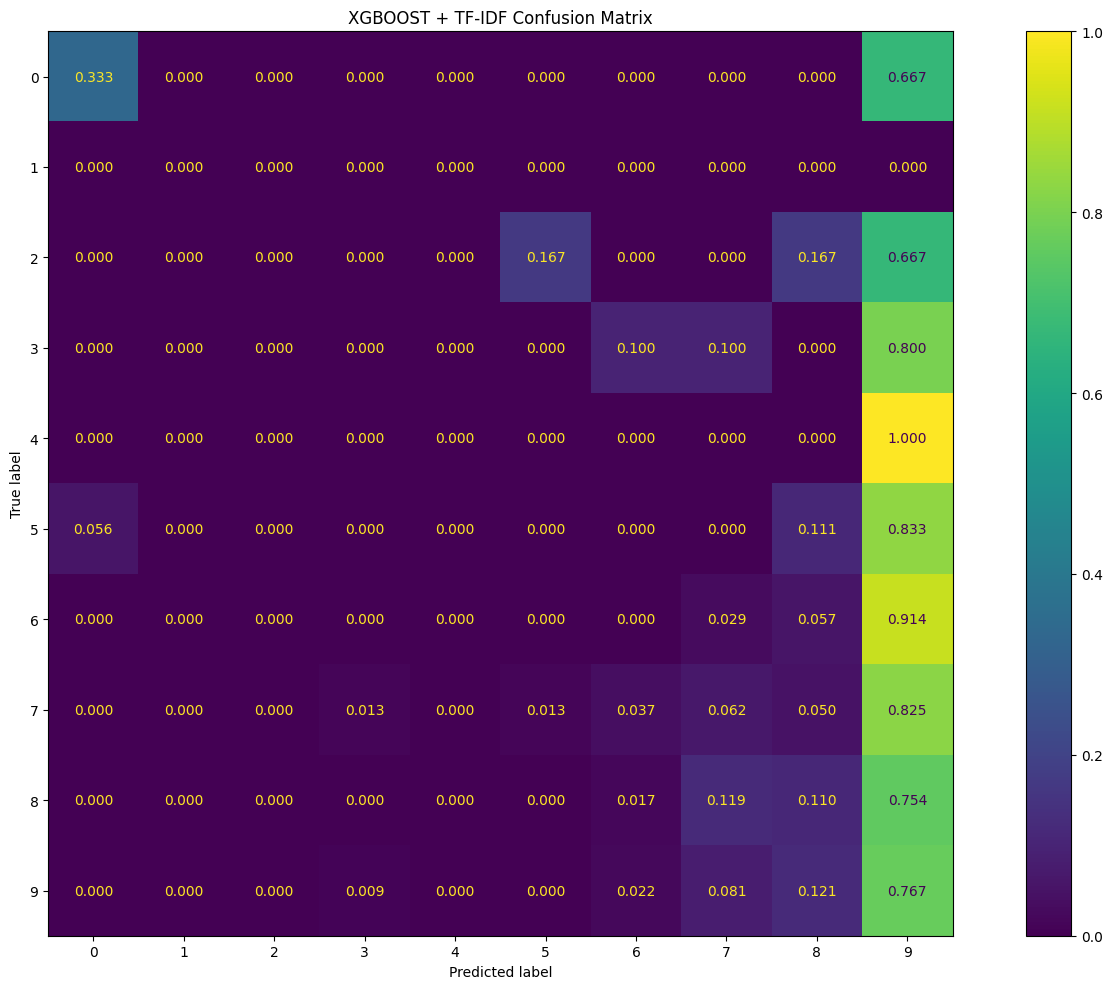

In [32]:
y_pred_xgb_tf, y_test_xgb_tf, x_train_tf, x_test_tf, y_train_tf, xgb_model_tf = run_xgboost(x_tf_idf, y, "TF-IDF")
create_conf_matrix(y_test_xgb_tf, y_pred_xgb_tf, "XGBOOST + TF-IDF Confusion Matrix")

Test Accuracy: 0.4
Classification Report:
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00        18
         6.0       0.09      0.06      0.07        35
         7.0       0.25      0.11      0.16        80
         8.0       0.25      0.10      0.14       118
         9.0       0.45      0.79      0.58       223

    accuracy                           0.40       500
   macro avg       0.15      0.15      0.14       500
weighted avg       0.31      0.40      0.32       500

F-2 score: 0.36


<Figure size 800x500 with 0 Axes>

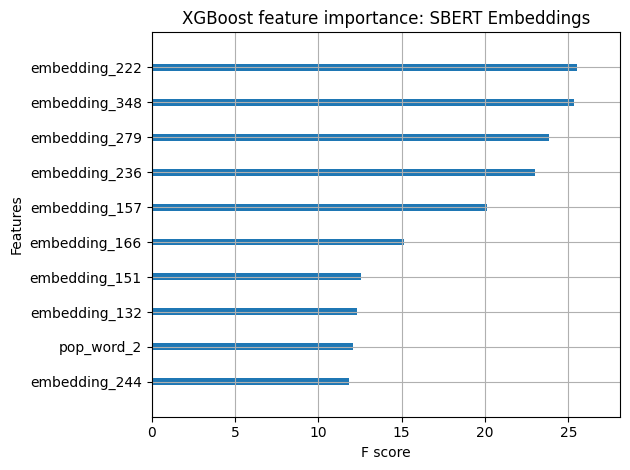

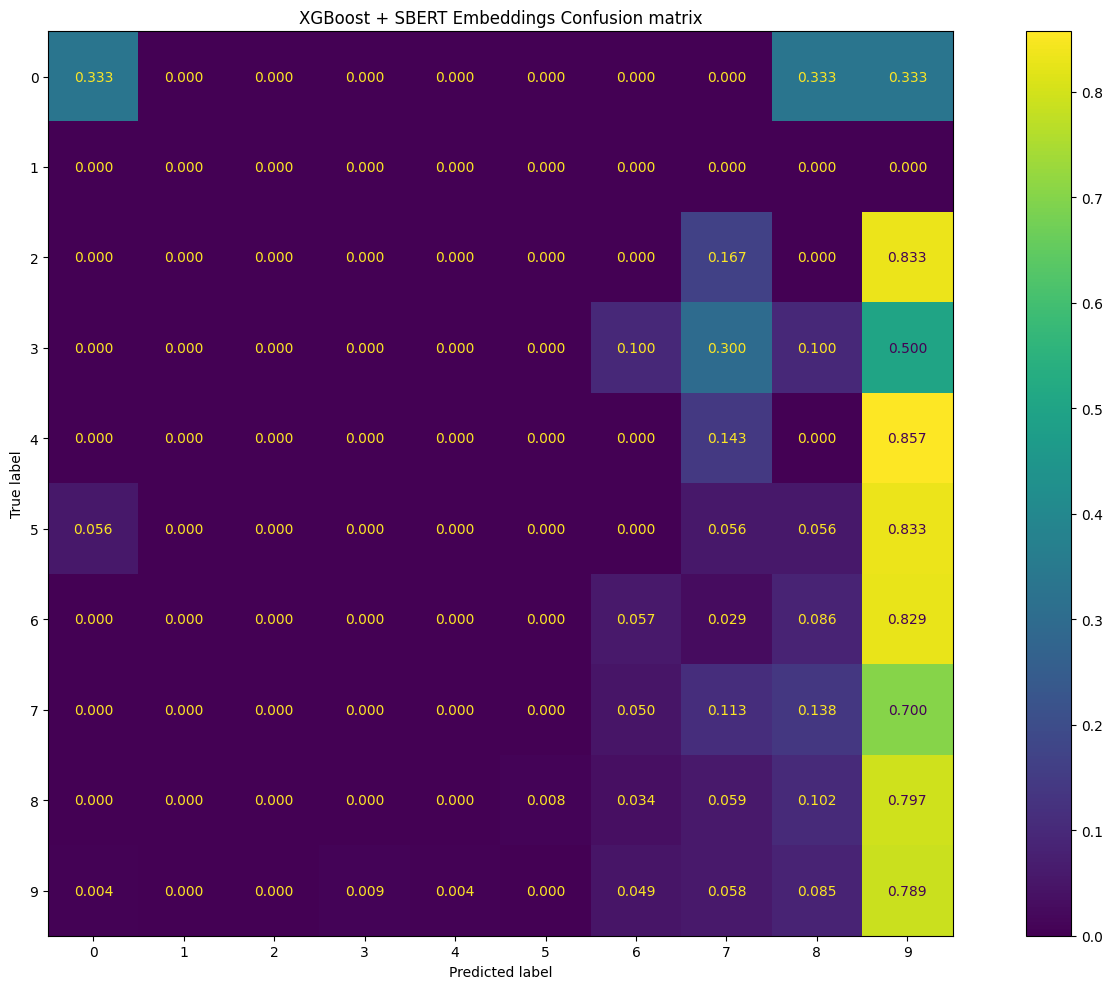

In [33]:
y_pred_xgb_emb, y_pred_test_emb, x_train_emb, x_test_emb, y_train_emb, xgb_model_emb = run_xgboost(x_sbert_embedding, y, "SBERT Embeddings")
create_conf_matrix(y_pred_test_emb, y_pred_xgb_emb, "XGBoost + SBERT Embeddings Confusion matrix")

# Advanced model - Simple NN

In [34]:
def convert_to_torch(x_matrix, y_mat):
    X_train, X_test, y_train, y_test = train_test_split(x_matrix, y_mat, test_size=0.2, random_state=42)
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)

    y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    batch_size = 32
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    test_dataset = TensorDataset(X_test_torch, y_test_torch)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    input_size = X_train.shape[1]
    return input_size, train_loader, test_loader, y_test

input_size, train_loader, test_loader, y_test = convert_to_torch(np.array(x_tf_idf), y)

In [35]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


In [36]:
class EmpathyNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmpathyNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmpathyNN(input_size, NUM_LABELS).to(device)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/30], Loss: 1.2364
Epoch [2/30], Loss: 1.0067
Epoch [3/30], Loss: 0.9740
Epoch [4/30], Loss: 0.9089
Epoch [5/30], Loss: 0.8578
Epoch [6/30], Loss: 0.8052
Epoch [7/30], Loss: 0.7073
Epoch [8/30], Loss: 0.6392
Epoch [9/30], Loss: 0.6023
Epoch [10/30], Loss: 0.5004
Epoch [11/30], Loss: 0.4506
Epoch [12/30], Loss: 0.4053
Epoch [13/30], Loss: 0.3686
Epoch [14/30], Loss: 0.3290
Epoch [15/30], Loss: 0.3189
Epoch [16/30], Loss: 0.2661
Epoch [17/30], Loss: 0.2501
Epoch [18/30], Loss: 0.2026
Epoch [19/30], Loss: 0.1892
Epoch [20/30], Loss: 0.1896
Epoch [21/30], Loss: 0.2023
Epoch [22/30], Loss: 0.1684
Epoch [23/30], Loss: 0.1316
Epoch [24/30], Loss: 0.1330
Epoch [25/30], Loss: 0.1236
Epoch [26/30], Loss: 0.1266
Epoch [27/30], Loss: 0.1218
Epoch [28/30], Loss: 0.1277
Epoch [29/30], Loss: 0.1141
Epoch [30/30], Loss: 0.1142


In [38]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred_batch = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred_list.extend(y_pred_batch)

print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00        18
         6.0       0.07      0.06      0.06        35
         7.0       0.13      0.20      0.16        80
         8.0       0.20      0.08      0.12       118
         9.0       0.43      0.51      0.47       223

    accuracy                           0.28       500
   macro avg       0.09      0.09      0.09       500
weighted avg       0.26      0.28      0.27       500



# Advanced model -  LSTM

In [39]:
def plot_loss(feature_type, train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"LSTM Model - Train and Validation Loss ({feature_type})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out


In [ ]:
batch_size = 32
class LSTMSBERT(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMSBERT, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

def train_lstm_model(X_features, y, feature_type="TF-IDF", hidden_size=128, batch_size=32,
                     num_epochs=30, patience=10, lr=0.001, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    num_classes = len(set(y))

    X_train, X_test, y_train, y_test = train_test_split(
        np.array(X_features), y, test_size=0.2, random_state=seed, stratify=y
    )

    smote = SMOTE(random_state=seed)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    X_train_torch = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_resampled.to_numpy(), dtype=torch.long)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size, shuffle=False)

    input_size = X_train.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMSBERT(input_size, hidden_size, num_classes).to(device)
    criterion = FocalLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping...")
                break


    plot_loss(feature_type, train_losses, val_losses)

    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_list.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_test, y_pred_list))

    create_conf_matrix(y_test, y_pred_list, model_name=f"LSTM Confusion Matrix ({feature_type})")

    return model, X_train_torch, y_train_torch, X_test_torch, y_test_torch, y_pred_list

Epoch [1/30], Train Loss: 1.5251, Val Loss: 1.6566
Epoch [2/30], Train Loss: 0.6953, Val Loss: 1.3519
Epoch [3/30], Train Loss: 0.4784, Val Loss: 1.3954
Epoch [4/30], Train Loss: 0.3986, Val Loss: 1.5505
Epoch [5/30], Train Loss: 0.3634, Val Loss: 1.6552
Epoch [6/30], Train Loss: 0.3307, Val Loss: 1.6692
Epoch [7/30], Train Loss: 0.3163, Val Loss: 1.5996
Epoch [8/30], Train Loss: 0.3012, Val Loss: 1.7341
Epoch [9/30], Train Loss: 0.2874, Val Loss: 1.7774
Epoch [10/30], Train Loss: 0.2778, Val Loss: 1.7995
Epoch [11/30], Train Loss: 0.2742, Val Loss: 1.7454
Epoch [12/30], Train Loss: 0.2610, Val Loss: 1.8686
Early stopping triggered.


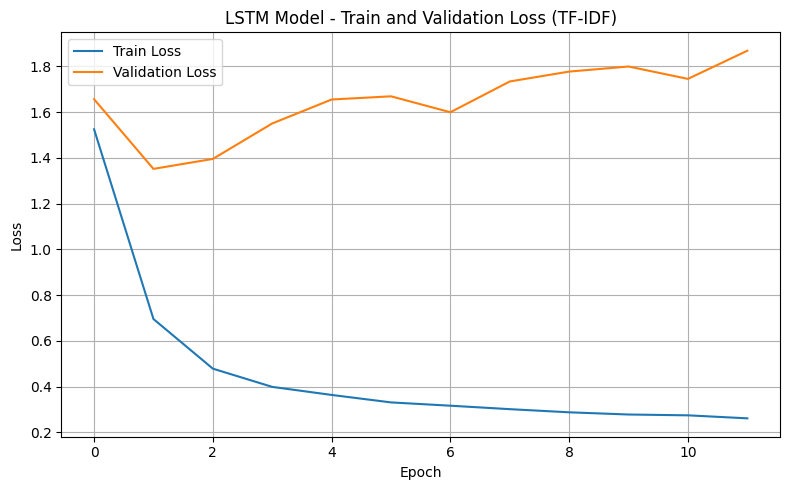


Classification Report:
              precision    recall  f1-score   support

         0.0       0.07      0.20      0.11         5
         1.0       0.00      0.00      0.00         2
         2.0       0.09      0.25      0.13         4
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         8
         5.0       0.02      0.07      0.03        15
         6.0       0.12      0.23      0.16        39
         7.0       0.14      0.26      0.19        80
         8.0       0.24      0.18      0.21        98
         9.0       0.51      0.16      0.25       240

    accuracy                           0.18       500
   macro avg       0.12      0.14      0.11       500
weighted avg       0.33      0.18      0.20       500



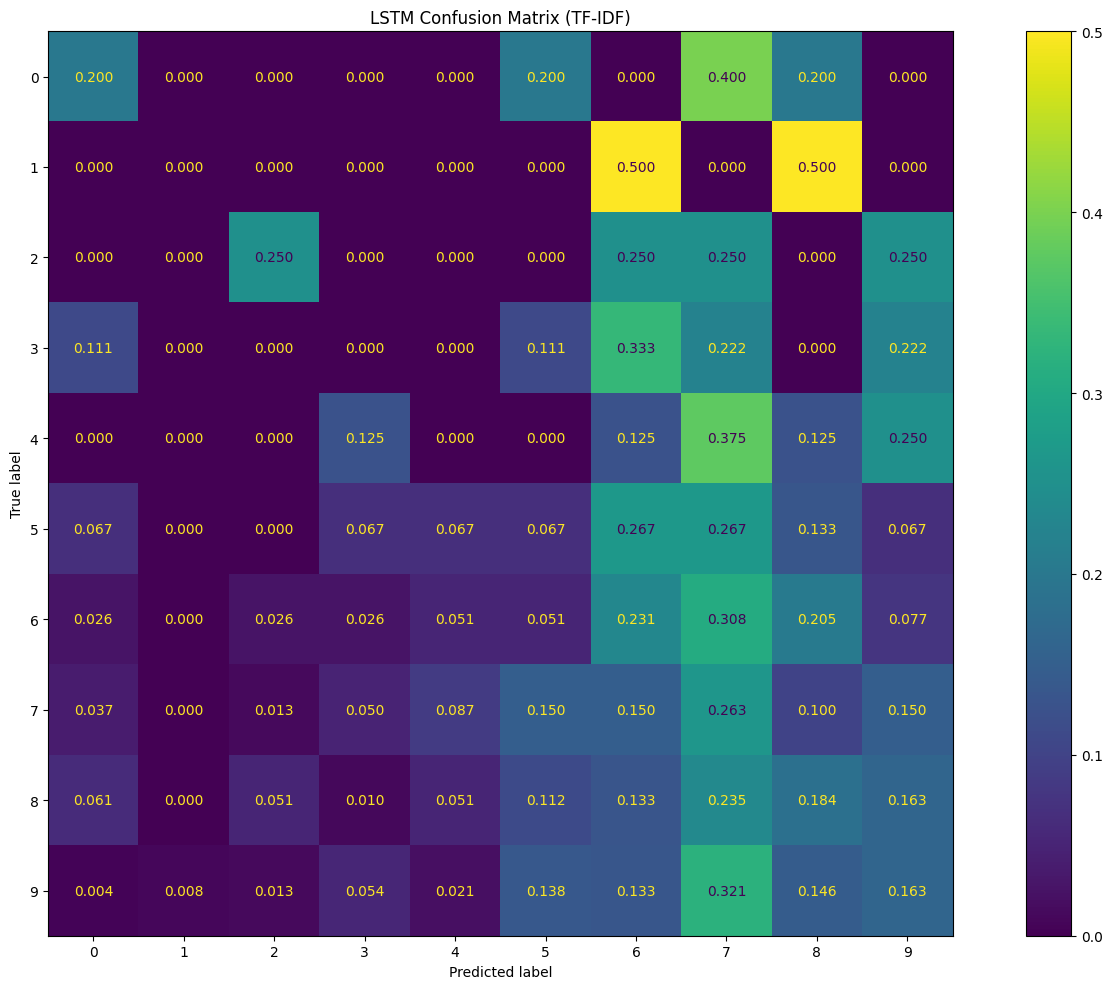

Epoch [1/30], Train Loss: 1.5795, Val Loss: 1.5587
Epoch [2/30], Train Loss: 0.8850, Val Loss: 1.6039
Epoch [3/30], Train Loss: 0.6296, Val Loss: 1.5684
Epoch [4/30], Train Loss: 0.5156, Val Loss: 1.4595
Epoch [5/30], Train Loss: 0.4494, Val Loss: 1.5860
Epoch [6/30], Train Loss: 0.4038, Val Loss: 1.4641
Epoch [7/30], Train Loss: 0.3664, Val Loss: 1.4671
Epoch [8/30], Train Loss: 0.3335, Val Loss: 1.4929
Epoch [9/30], Train Loss: 0.3107, Val Loss: 1.6323
Epoch [10/30], Train Loss: 0.2907, Val Loss: 1.5472
Epoch [11/30], Train Loss: 0.2774, Val Loss: 1.6227
Epoch [12/30], Train Loss: 0.2566, Val Loss: 1.6854
Epoch [13/30], Train Loss: 0.2482, Val Loss: 1.5411
Epoch [14/30], Train Loss: 0.2313, Val Loss: 1.5939
Early stopping triggered.


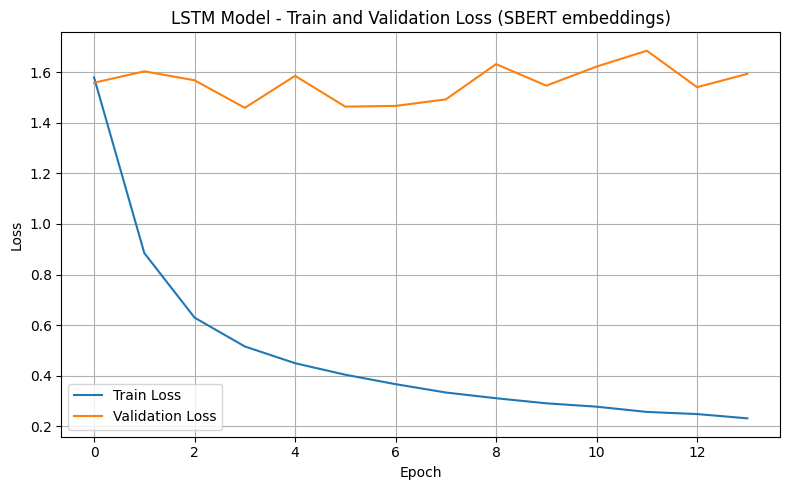


Classification Report:
              precision    recall  f1-score   support

         0.0       0.25      0.20      0.22         5
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         8
         5.0       0.05      0.13      0.07        15
         6.0       0.11      0.46      0.17        39
         7.0       0.17      0.23      0.20        80
         8.0       0.29      0.02      0.04        98
         9.0       0.51      0.22      0.31       240

    accuracy                           0.19       500
   macro avg       0.14      0.13      0.10       500
weighted avg       0.34      0.19      0.21       500



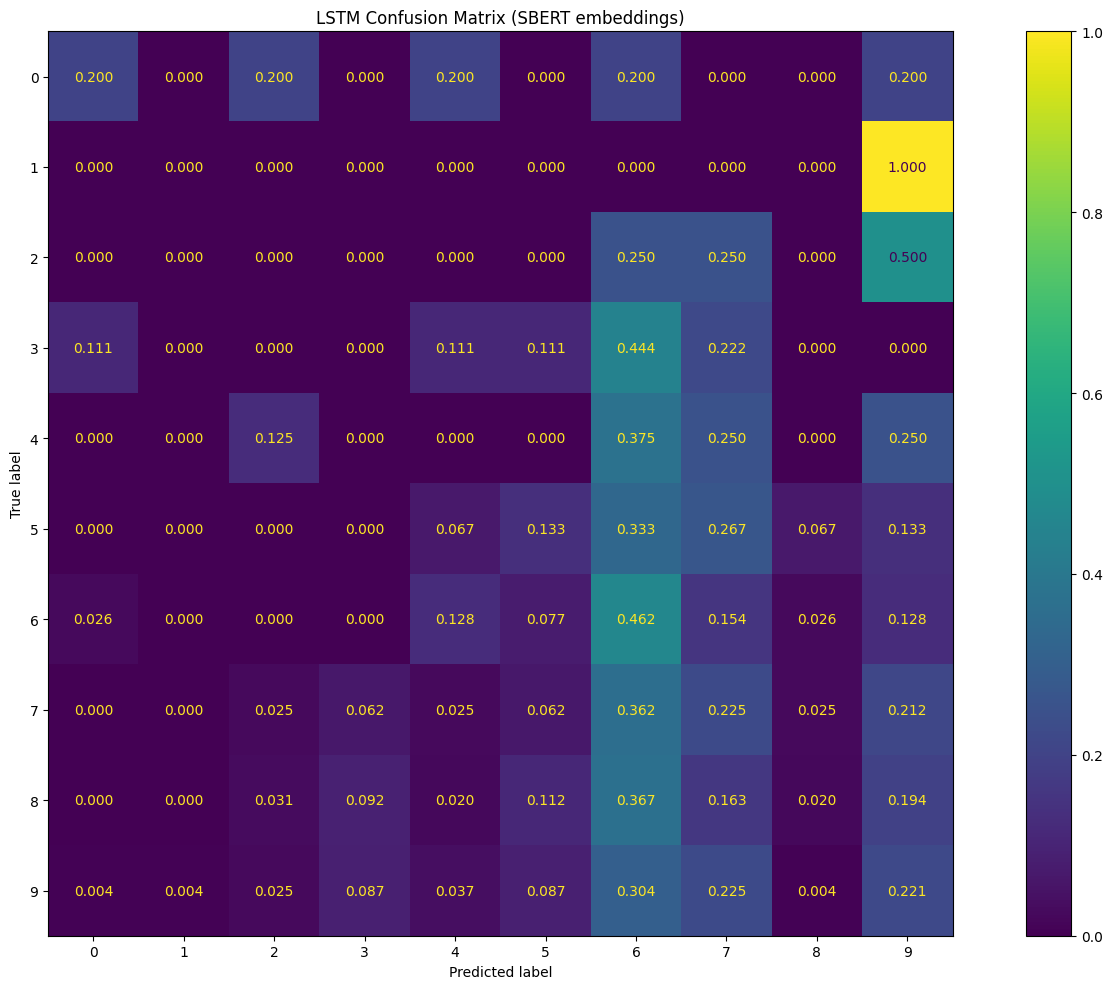

In [42]:
# Train on TF-IDF
lstm_tf, X_train_torch_tf, y_train_torch_tf, X_test_torch_tf, y_test_torch_tf, y_pred_lstm_tf = train_lstm_model(x_tf_idf, y, feature_type="TF-IDF")


# Train on SBERT embeddings
lstm_emb, X_train_torch_emb, y_train_torch_emb, X_test_torch_emb, y_test_torch_emb, y_pred_lstm_emb = train_lstm_model(x_sbert_embedding, y, feature_type="SBERT embeddings")


# Plot label distribution

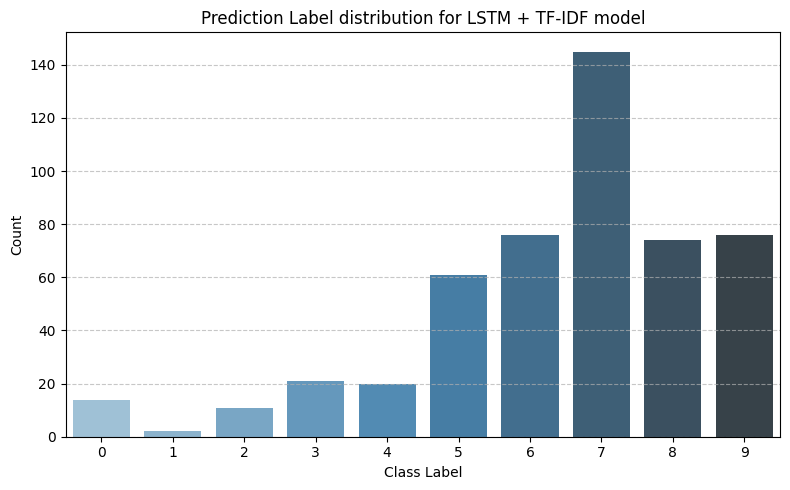

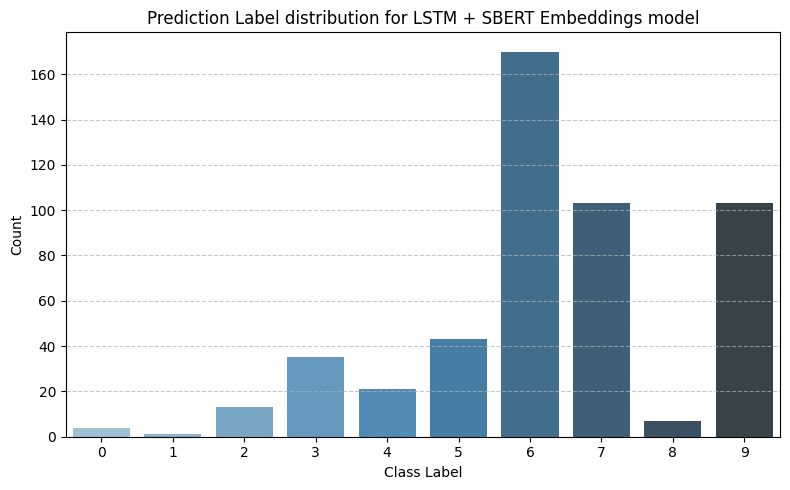

In [52]:
plot_label_distribution(y_pred_lstm_tf, "Prediction Label distribution for LSTM + TF-IDF model")

plot_label_distribution(y_pred_lstm_emb, "Prediction Label distribution for LSTM + SBERT Embeddings model")

# Feature importance

In [ ]:
def prepare_data(X, y, model_type='torch'):
    if model_type == 'torch':
        return X.numpy(), y.numpy()
    else:
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        return X_np, y

In [ ]:
def get_model_predictions(model, X, model_type='torch', batch_size=None, device=None):
    if model_type == 'torch':
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(X), batch_size):
                batch = X[i:i+batch_size].to(device)
                outputs = model(batch)
                predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        return predictions
    
    elif model_type == 'xgboost':
        return model.predict(X)
    
    else:
        raise ValueError("model_type must be 'torch' or 'xgboost'")

In [45]:
def plot_feat_importance(importances, feature_names, title, top_n=10, figsize=(10, 6)):
    sorted_idx = np.argsort(importances)[::-1]
    top_features = [feature_names[i] for i in sorted_idx[:top_n]]
    top_values = importances[sorted_idx[:top_n]]
    
    plt.figure(figsize=figsize)
    plt.barh(top_features[::-1], top_values[::-1])
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [46]:
def permutation_importance(model, X, y, feature_names, model_type='torch', 
                          batch_size=None, device=None, metric_fn=accuracy_score):
    base_preds = get_model_predictions(model, X, model_type, batch_size, device)
    X_np, y_np = prepare_data(X, y, model_type)
    base_score = metric_fn(y_np, base_preds) 
    importances = []
    for i in range(X_np.shape[1]):
        X_permuted = copy.deepcopy(X_np)
        np.random.shuffle(X_permuted[:, i])
        if model_type == 'torch':
            X_permuted_torch = torch.tensor(X_permuted, dtype=torch.float32).to(device)
            permuted_preds = get_model_predictions(model, X_permuted_torch, model_type, batch_size, device)
        else:
            permuted_preds = get_model_predictions(model, X_permuted, model_type, batch_size, device)
        
        score = metric_fn(y_np, permuted_preds)
        importances.append(base_score - score)
    
    return np.array(importances)

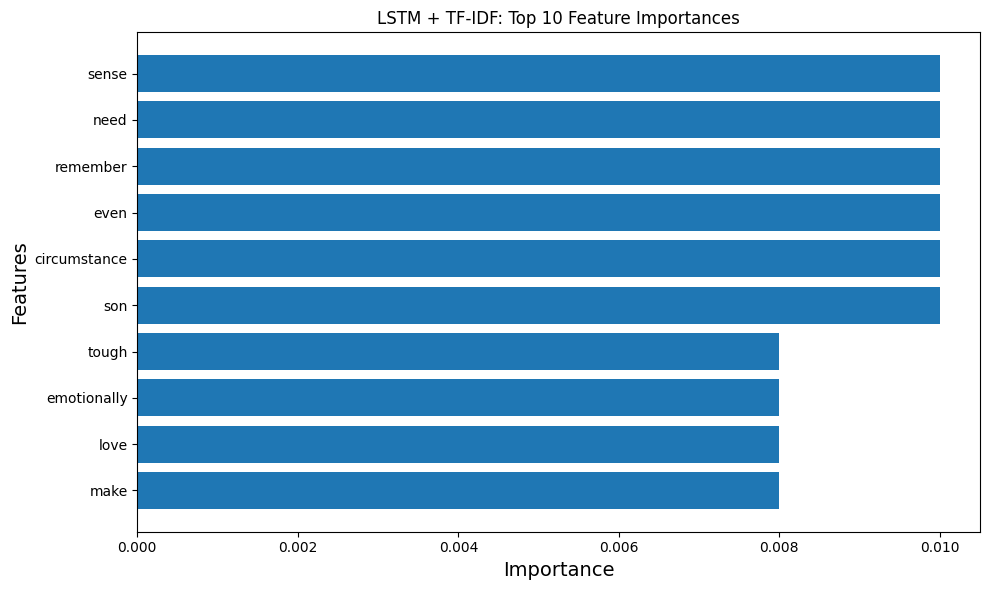

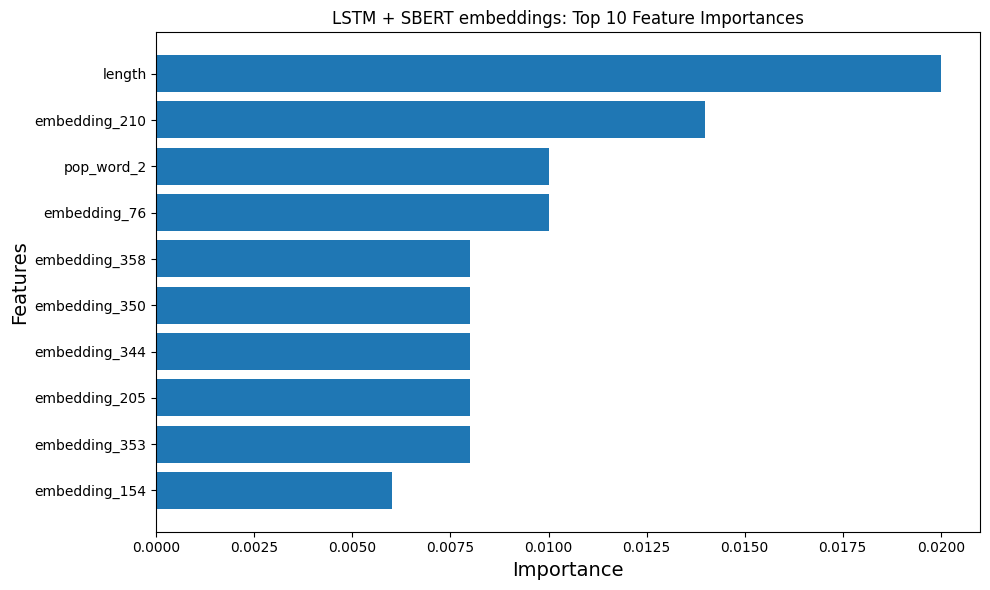

In [47]:
# For TF-IDF
importances_tf = permutation_importance(
    model=lstm_tf,
    X=X_test_torch_tf,
    y=y_test_torch_tf,
    feature_names=x_tf_idf.columns,
    model_type='torch',
    batch_size=batch_size,
    device=device
)

# For SBERT Embeddings
embedding_feature_names = [f"dim_{i}" for i in range(x_sbert_embedding.shape[1])]
importances_emb = permutation_importance(
    model=lstm_emb,
    X=X_test_torch_emb,
    y=y_test_torch_emb,
    feature_names=embedding_feature_names,
    model_type='torch',
    batch_size=batch_size,
    device=device,
)

plot_feat_importance(importances_tf, x_tf_idf.columns, 
               "LSTM + TF-IDF: Top 10 Feature Importances", top_n=10)

plot_feat_importance(importances_emb, x_sbert_embedding.columns, 
               "LSTM + SBERT embeddings: Top 10 Feature Importances", top_n=10)


In [48]:
def plot_train_test_comparison(train_importances, test_importances, feature_names, 
                              title, top_n=10):
    """Plot side-by-side comparison of train vs test feature importance."""
    train_top_idx = np.argsort(train_importances)[::-1][:top_n]
    test_top_idx = np.argsort(test_importances)[::-1][:top_n]
    
    train_features = [feature_names[i] for i in train_top_idx]
    test_features = [feature_names[i] for i in test_top_idx]
    train_values = train_importances[train_top_idx]
    test_values = test_importances[test_top_idx]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)
    
    # Train subplot
    axes[0].barh(train_features[::-1], train_values[::-1])
    axes[0].set_title(f"{title} - Train")
    axes[0].set_xlabel("Importance", fontsize=14)
    axes[0].set_ylabel("Feature Name", fontsize=14)
    
    # Test subplot
    axes[1].barh(test_features[::-1], test_values[::-1])
    axes[1].set_title(f"{title} - Test")
    axes[1].set_xlabel("Importance", fontsize=14)
    axes[1].set_ylabel("Feature Name", fontsize=14)
    
    fig.suptitle(f"{title} - Feature Importance Train vs Test Comparison", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [49]:
def analyze_feature_importance(model, X_train, y_train, X_test, y_test, 
                             feature_names, title, model_type='torch',
                             batch_size=None, device=None, top_n=10, metric_fn=accuracy_score):
    # Calculate importances
    train_importances = permutation_importance(
        model=model, X=X_train, y=y_train, feature_names=feature_names,
        model_type=model_type, batch_size=batch_size, device=device,
        metric_fn=metric_fn
    )
    
    test_importances = permutation_importance(
        model=model, X=X_test, y=y_test, feature_names=feature_names,
        model_type=model_type, batch_size=batch_size, device=device,
        metric_fn=metric_fn
    )
    
    # Plot comparison
    plot_train_test_comparison(train_importances, test_importances, 
                              feature_names, title, top_n)
    
    return train_importances, test_importances


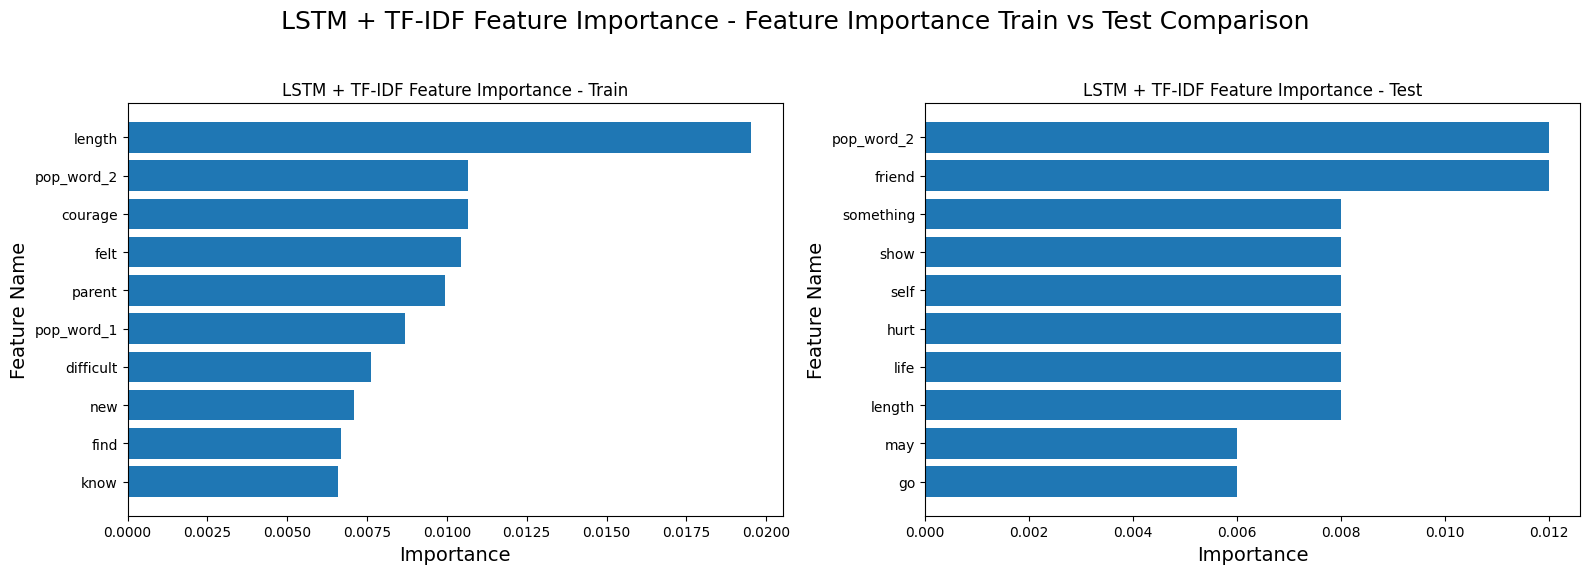

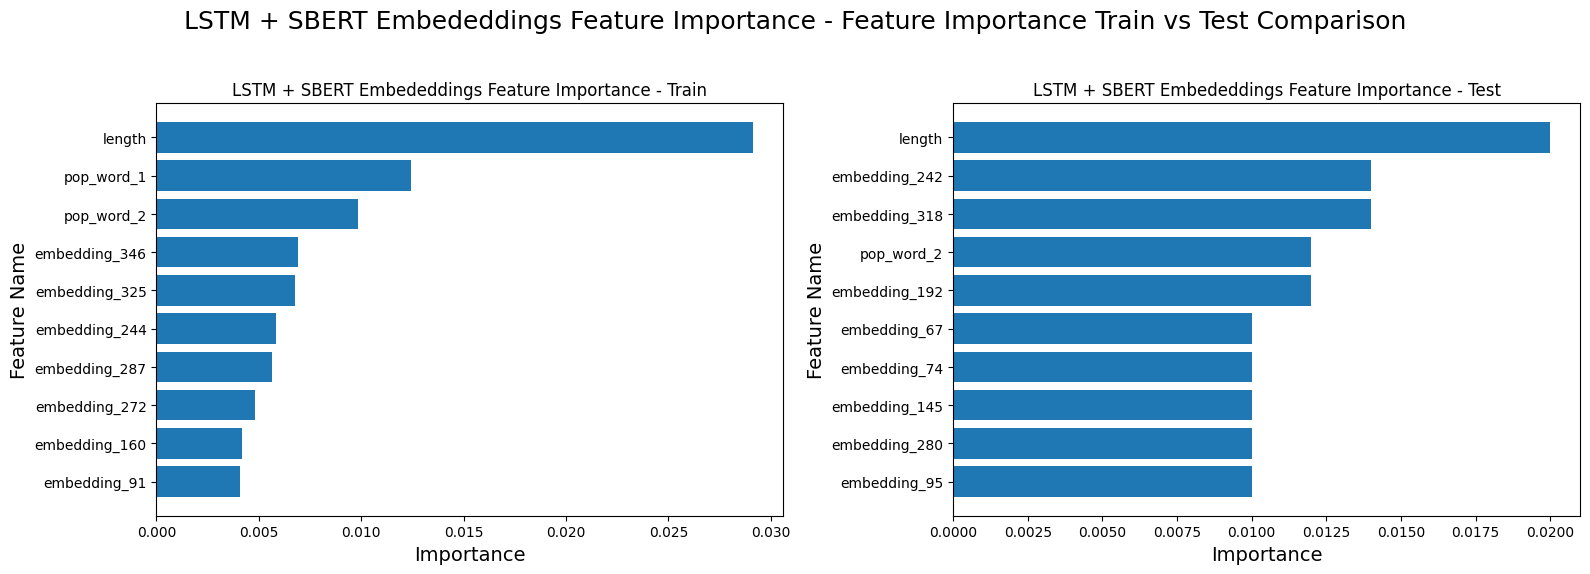

In [50]:
# lstm
train_lstm_imp_tf, test_lstm_imp_tf = analyze_feature_importance(
    model=lstm_tf,
    X_train=X_train_torch_tf,
    y_train=y_train_torch_tf,
    X_test=X_test_torch_tf,
    y_test=y_test_torch_tf,
    feature_names=x_tf_idf.columns,
    title="LSTM + TF-IDF Feature Importance",
    model_type='torch',
    batch_size=batch_size,
    device=device,
    top_n=10
)

train_lstm_imp_sbert, test_lstm_imp_sbert = analyze_feature_importance(
    model=lstm_emb,
    X_train=X_train_torch_emb,
    y_train=y_train_torch_emb,
    X_test=X_test_torch_emb,
    y_test=y_test_torch_emb,
    feature_names=x_sbert_embedding.columns,
    title="LSTM + SBERT Embededdings Feature Importance",
    model_type='torch',
    batch_size=batch_size,
    device=device,
    top_n=10
)



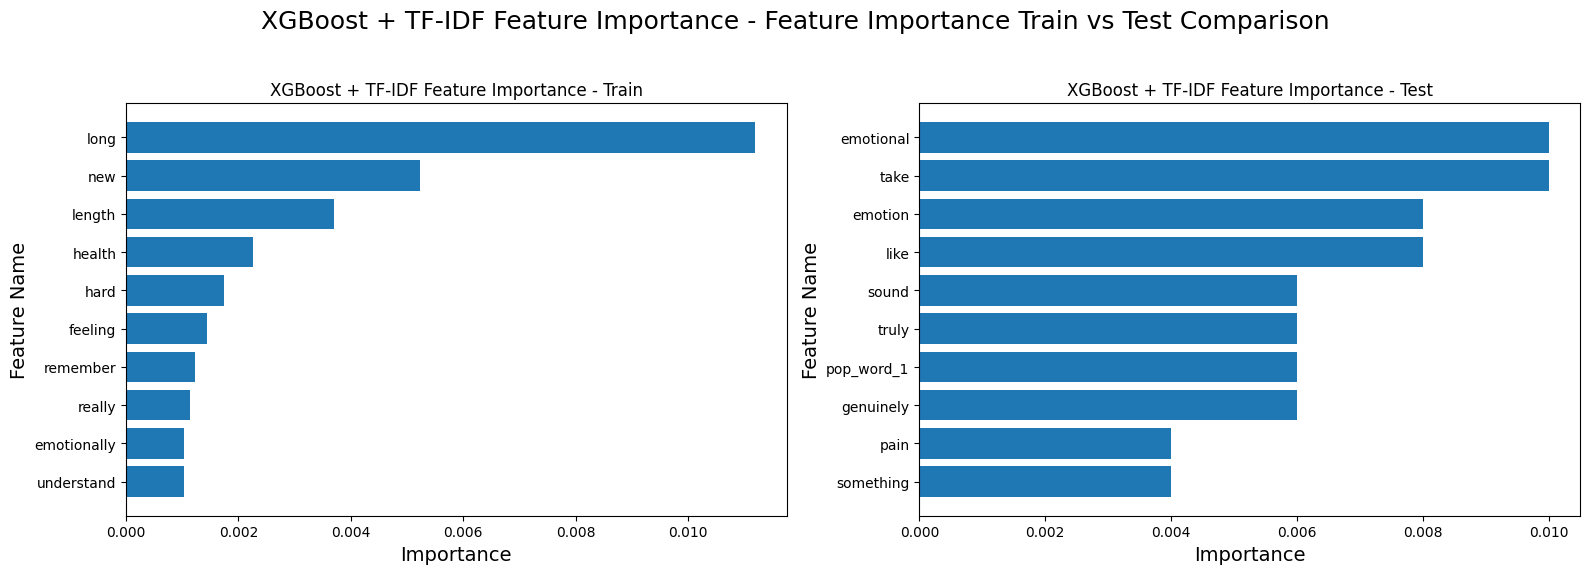

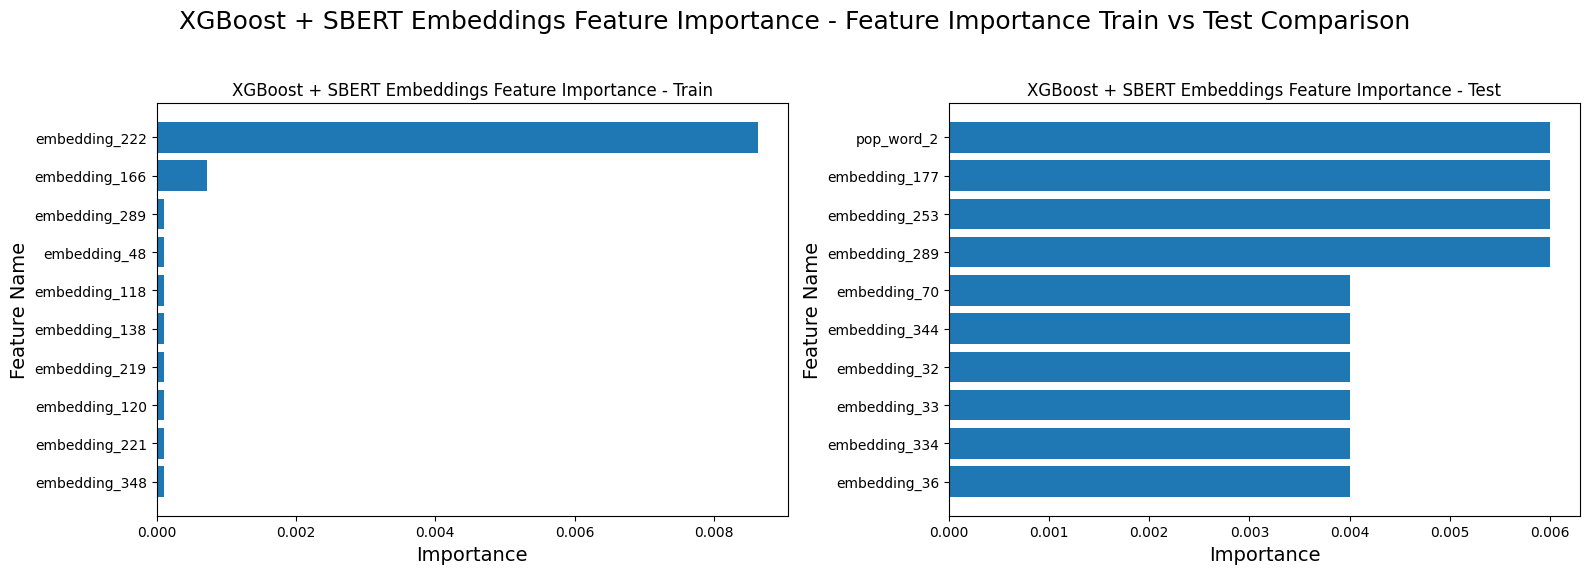

(array([ 0.        ,  0.        ,  0.00010267,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00010267,  0.        ,  0.        ,
         0.        ,  0.00010267,  0.        ,  0.        ,  0.00010267,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00010267,  0.        ,  0.        , -0.00010267,
        -0.00010267,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00010267,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00010267,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00010267, -0.00010267,
        -0.00010267,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00010267,  0.        ,  0.00010267,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00010267,  0. 

In [51]:
# xgboost
analyze_feature_importance(
    model=xgb_model_tf,
    X_train=x_train_tf,
    y_train=y_train_tf,
    X_test=x_test_tf,
    y_test=y_test_xgb_tf,
    feature_names=x_tf_idf.columns,
    title="XGBoost + TF-IDF Feature Importance",
    model_type='xgboost',
    top_n=10
)

analyze_feature_importance(
    model=xgb_model_emb,
    X_train=x_train_emb,
    y_train=y_train_emb,
    X_test=x_test_emb,
    y_test=y_pred_test_emb,
    feature_names=x_sbert_embedding.columns,
    title="XGBoost + SBERT Embeddings Feature Importance",
    model_type='xgboost',
    top_n=10
)